In [18]:
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from gensim.models import KeyedVectors
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB


In [2]:
ds_volume = load_dataset("AI-team-UoA/greek_legal_code", "volume")
ds_chapter = load_dataset("AI-team-UoA/greek_legal_code", "chapter")
ds_subject = load_dataset("AI-team-UoA/greek_legal_code", "subject")

df_volume = ds_volume['train'].to_pandas()
df_chapter = ds_chapter['train'].to_pandas()
df_subject = ds_subject['train'].to_pandas()

df_volume.head()



,text,label
0,5. ΑΝΑΓΚ. ΝΟΜΟΣ 1204 της 20/29 Απρ. 1938 Περί...,41
1,15. ΝΟΜΟΘΕΤ.ΔΙΑΤΑΓΜΑ υπ’ αριθ.262 της 8/8 Ιουλ...,35
2,29. ΝΟΜΟΘΕΤ. ΔΙΑΤΑΓΜΑ υπ’ αριθ. 1164 της 4 Μαρ...,6
3,29. ΠΡΟΕΔΡΙΚΟ ΔΙΑΤΑΓΜΑ υπ’ αριθ. 384 της 16/25...,4
4,6. ΝΟΜΟΣ υπ’ αριθ. 213 της 13/20 Νοεμ. 1975 (Φ...,43


In [3]:
print(f"Volume dataset: {df_volume.shape}")
print(f"Chapter dataset: {df_chapter.shape}")
print(f"Subject dataset: {df_subject.shape}")

Volume dataset: (28536, 2)
Chapter dataset: (28536, 2)
Subject dataset: (28536, 2)


In [12]:
#Cleaning the text
def clean_word(word):
    word = word.lower()
    word = re.sub(r'\d+', '', word)
    word = re.sub(r'[^\w\s]', '', word)
    word = re.sub(r'\s+', ' ', word).strip()
    return word


# General idea - Dummy Classifier Tf - idf

In [14]:
def dummy_tfidf(df, stopwords_path='stopwords-el.txt', max_features=10000):
    """
    TF-IDF + DummyClassifier για  baseline.
    """

    # Loading stopwords
    with open(stopwords_path, encoding='utf-8') as f:
        stopwords = [re.sub(r'[^\w\s]', '', line.strip().lower()) for line in f if line.strip()]

    # Removal of labels with less than 5 samples
    label_counts = df['label'].value_counts()
    valid_labels = label_counts[label_counts >= 5].index
    df_filtered = df[df['label'].isin(valid_labels)].copy()

    df_filtered['clean_text'] = df_filtered['text'].apply(clean_text)

    X = df_filtered['clean_text']
    y = df_filtered['label']

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer(max_features=max_features, stop_words=stopwords)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Dummy Classifier
    clf = DummyClassifier(strategy="most_frequent")
    clf.fit(X_train_tfidf, y_train)

    # Prediction and evaluation
    y_pred = clf.predict(X_test_tfidf)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    results = {
        'Accuracy': [report['accuracy']],
        'Precision (macro)': [report['macro avg']['precision']],
        'Recall (macro)': [report['macro avg']['recall']],
        'F1-score (macro)': [report['macro avg']['f1-score']],
        'Precision (weighted)': [report['weighted avg']['precision']],
        'Recall (weighted)': [report['weighted avg']['recall']],
        'F1-score (weighted)': [report['weighted avg']['f1-score']]
    }

    df_results = pd.DataFrame(results, index=['Dummy Classifier'])
    return df_results


## Subject

In [ ]:
label_counts_subject = df_subject['label'].value_counts()
valid_labels_subject = label_counts_subject[label_counts_subject >= 2].index
df_subject_filtered = df_subject[df_subject['label'].isin(valid_labels_subject)].copy()

df_sub_dummy_tf = dummy_tfidf(df_subject_filtered)
display(df_sub_dummy_tf)


,Accuracy,Precision (macro),Recall (macro),F1-score (macro),Precision (weighted),Recall (weighted),F1-score (weighted)
Dummy Classifier,0.029887,0.000024,0.000811,0.000047,0.000893,0.029887,0.001735


## Chapter

In [ ]:
label_counts_chapter = df_chapter['label'].value_counts()
valid_labels_chapter = label_counts_chapter[label_counts_chapter >= 2].index
df_chapter_filtered = df_chapter[df_chapter['label'].isin(valid_labels_chapter)].copy()

df_chap_dummy_tf = dummy_tfidf(df_chapter_filtered)
display(df_chap_dummy_tf)


,Accuracy,Precision (macro),Recall (macro),F1-score (macro),Precision (weighted),Recall (weighted),F1-score (weighted)
Dummy Classifier,0.027734,0.000077,0.002762,0.000149,0.000769,0.027734,0.001497


## Volume

In [ ]:
df_vol_dummy_tf = dummy_tfidf(df_volume)
display(df_vol_dummy_tf)

,Accuracy,Precision (macro),Recall (macro),F1-score (macro),Precision (weighted),Recall (weighted),F1-score (weighted)
Dummy Classifier,0.073406,0.001562,0.021277,0.00291,0.005388,0.073406,0.01004


# B1.i

In [16]:
def process_and_train_svm(df_chapter, stopwords_path='stopwords-el.txt',
                          max_features=10000, vectorizer_type='bow'):
    """
    Εκπαιδεύει SVM με επιλογή ανάμεσα σε BoW ή TF-IDF.
    """
    # Loading stopwords
    with open(stopwords_path, encoding='utf-8') as f:
        stopwords_el = [clean_word(line) for line in f if line.strip()]

    # Filtering labels with less than 5 samples
    label_counts = df_chapter['label'].value_counts()
    valid_labels = label_counts[label_counts >= 5].index
    df_filtered = df_chapter[df_chapter['label'].isin(valid_labels)]

    X = df_filtered['text']
    y = df_filtered['label']

    # Train/Validation/Test split
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
    )

    # Choose vectorizer
    if vectorizer_type == 'bow':
        vectorizer = CountVectorizer(max_features=max_features, stop_words=stopwords_el)
    elif vectorizer_type == 'tfidf':
        vectorizer = TfidfVectorizer(max_features=max_features, stop_words=stopwords_el)
    else:
        raise ValueError("vectorizer_type must be 'bow' or 'tfidf'")

    X_train_vec = vectorizer.fit_transform(X_train)
    X_val_vec = vectorizer.transform(X_val)
    X_test_vec = vectorizer.transform(X_test)

    # SVM + GridSearch
    svc = LinearSVC()
    param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 100]}
    grid_search = GridSearchCV(
        estimator=svc,
        param_grid=param_grid,
        scoring='f1_macro',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_val_vec, y_val)

    print(f"\n Best parameter (C) for {vectorizer_type.upper()}: {grid_search.best_params_}")

    # Train the best model on the full training set
    best_model = grid_search.best_estimator_
    best_model.fit(vectorizer.transform(X_train_full), y_train_full)

    # Evaluate on the test set
    y_pred = best_model.predict(X_test_vec)

    print("\n Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    metrics_df = pd.DataFrame([{
        'Model': f'SVM + {vectorizer_type.upper()}',
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision (macro)': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'Recall (macro)': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'F1-score (macro)': f1_score(y_test, y_pred, average='macro', zero_division=0),
        'Precision (weighted)': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall (weighted)': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1-score (weighted)': f1_score(y_test, y_pred, average='weighted', zero_division=0)
    }]).set_index('Model')

    return metrics_df


## BOW

### Subject

In [ ]:
results_svm_bow_sub = process_and_train_svm(df_subject, vectorizer_type='bow')
display(results_svm_bow_sub)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 Best parameter (C) for BOW: {'C': 0.05}


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.50      0.46         6
           8       0.83      0.83      0.83         6
           9       0.50      0.33      0.40         3
          11       1.00      1.00      1.00         1
          13       0.50      0.33      0.40         3
          17       1.00      1.00      1.00         4
          19       0.00      0.00      0.00         3
          20       0.50      0.50      0.50         2
          22       0.00      0.00      0.00         1
          25       0.80      0.67      0.73        12
          27       0.67      0.50      0.57         4
          29       0.00      0.00      0.00         1
          30       0.50      0.33      0.40         3
          32       0.70      0.78      0.74         9
          33       1.00      0.67      0.80         3
          34       1.00      1.00      1.00         6
          37       0.67      1.00      0.80         2
  

,Accuracy,Precision (macro),Recall (macro),F1-score (macro),Precision (weighted),Recall (weighted),F1-score (weighted)
Model,,,,,,,
SVM + BOW,0.637406,0.554253,0.525795,0.521547,0.623081,0.637406,0.612828


### Chapter

In [ ]:
results_svm_bow_chap = process_and_train_svm(df_chapter, vectorizer_type='bow')
display(results_svm_bow_chap)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 Best parameter (C) for BOW: {'C': 0.1}


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        27
           1       0.77      0.62      0.69        16
           2       0.75      0.60      0.67         5
           3       1.00      0.54      0.70        13
           4       0.00      0.00      0.00         1
           5       0.73      0.57      0.64        14
           6       0.72      0.76      0.74        17
           7       0.83      0.83      0.83        12
           8       0.66      0.62      0.64        37
           9       0.50      0.33      0.40         3
          10       0.33      0.25      0.29         4
          11       0.74      0.77      0.76        22
          13       0.00      0.00      0.00         1
          14       0.88      0.67      0.76        21
          15       1.00      0.25      0.40         4
          16       0.00      0.00      0.00         4
          17       0.81      0.79      0.80        28
  

,Accuracy,Precision (macro),Recall (macro),F1-score (macro),Precision (weighted),Recall (weighted),F1-score (weighted)
Model,,,,,,,
SVM + BOW,0.68931,0.619234,0.56599,0.576559,0.69187,0.68931,0.682247


### Volume


In [ ]:
results_svm_bow_vol = process_and_train_svm(df_volume, vectorizer_type='bow')
display(results_svm_bow_vol)


Fitting 5 folds for each of 9 candidates, totalling 45 fits

 Best parameter (C) for BOW: {'C': 0.01}

 Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.67      0.71       112
           1       0.73      0.79      0.76       234
           2       0.85      0.70      0.77        47
           3       0.70      0.77      0.73       146
           4       0.75      0.78      0.77       208
           5       0.74      0.71      0.72        65
           6       0.94      0.82      0.88       135
           7       0.85      0.62      0.72        66
           8       0.84      0.75      0.79        55
           9       0.86      0.74      0.79        42
          10       0.90      0.64      0.74        96
          11       0.85      0.75      0.80       110
          12       0.97      0.72      0.83        50
          13       0.82      0.82      0.82        91
          14       0.82      0.76      0.79       102
        

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,Accuracy,Precision (macro),Recall (macro),F1-score (macro),Precision (weighted),Recall (weighted),F1-score (weighted)
Model,,,,,,,
SVM + BOW,0.781359,0.78448,0.740756,0.758667,0.784789,0.781359,0.779932


## TF-IDF

### CHAPTER

In [ ]:
results_svm_tf_chap = process_and_train_svm(df_chapter, vectorizer_type='tfidf')
display(results_svm_tf_chap)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 Best parameter (C) for TFIDF: {'C': 5}

 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87        27
           1       0.80      0.75      0.77        16
           2       0.60      0.60      0.60         5
           3       0.82      0.69      0.75        13
           4       0.00      0.00      0.00         1
           5       0.83      0.71      0.77        14
           6       0.70      0.94      0.80        17
           7       0.83      0.83      0.83        12
           8       0.78      0.68      0.72        37
           9       1.00      1.00      1.00         3
          10       0.25      0.25      0.25         4
          11       0.84      0.73      0.78        22
          13       0.00      0.00      0.00         1
          14       0.90      0.90      0.90        21
          15       1.00      1.00      1.00         4
          16       1.00      0.50      0.67         4
          17   

,Accuracy,Precision (macro),Recall (macro),F1-score (macro),Precision (weighted),Recall (weighted),F1-score (weighted)
Model,,,,,,,
SVM + TFIDF,0.751624,0.695698,0.660987,0.666224,0.751764,0.751624,0.745346


### SUBJECT

In [ ]:
results_svm_tf_sub = process_and_train_svm(df_subject, vectorizer_type='tfidf')
display(results_svm_tf_sub)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



 Best parameter (C) for TFIDF: {'C': 10}

 Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.33      0.44         6
           8       0.83      0.83      0.83         6
           9       0.50      0.33      0.40         3
          11       1.00      1.00      1.00         1
          13       0.33      0.33      0.33         3
          17       1.00      1.00      1.00         4
          19       0.00      0.00      0.00         3
          20       0.50      0.50      0.50         2
          22       1.00      1.00      1.00         1
          25       0.91      0.83      0.87        12
          27       0.40      0.50      0.44         4
          29       0.00      0.00      0.00         1
          30       1.00      0.33      0.50         3
          32       0.78      0.78      0.78         9
          33       1.00      1.00      1.00         3
          34       1.00      1.00      1.00         6
          37  

,Accuracy,Precision (macro),Recall (macro),F1-score (macro),Precision (weighted),Recall (weighted),F1-score (weighted)
Model,,,,,,,
SVM + TFIDF,0.694549,0.621555,0.616241,0.598766,0.686375,0.694549,0.675182


### VOLUME

In [ ]:
results_svm_tf_vol = process_and_train_svm(df_volume, vectorizer_type='tfidf')
display(results_svm_tf_vol)


Fitting 5 folds for each of 9 candidates, totalling 45 fits

 Best parameter (C) for TFIDF: {'C': 1}

 Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       112
           1       0.81      0.84      0.82       234
           2       0.80      0.77      0.78        47
           3       0.71      0.79      0.74       146
           4       0.79      0.83      0.81       208
           5       0.75      0.72      0.73        65
           6       0.94      0.87      0.90       135
           7       0.80      0.79      0.79        66
           8       0.87      0.84      0.85        55
           9       0.89      0.74      0.81        42
          10       0.91      0.75      0.82        96
          11       0.85      0.85      0.85       110
          12       0.95      0.82      0.88        50
          13       0.88      0.84      0.86        91
          14       0.88      0.81      0.85       102
         

,Accuracy,Precision (macro),Recall (macro),F1-score (macro),Precision (weighted),Recall (weighted),F1-score (weighted)
Model,,,,,,,
SVM + TFIDF,0.825158,0.823513,0.793945,0.806821,0.825982,0.825158,0.824162


# GRAPHS

<AxesSubplot:xlabel='label'>

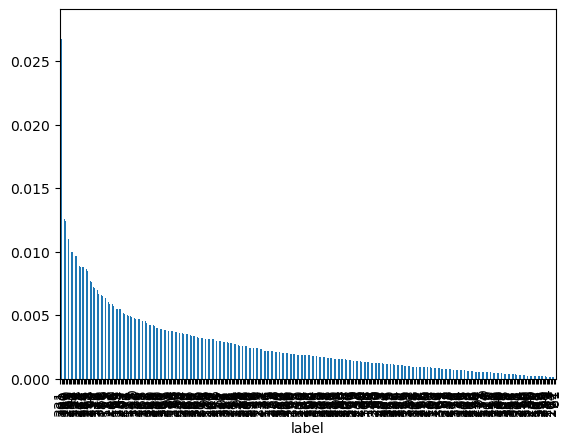

In [ ]:
y.value_counts(normalize=True).plot(kind='bar')


<AxesSubplot:xlabel='label'>

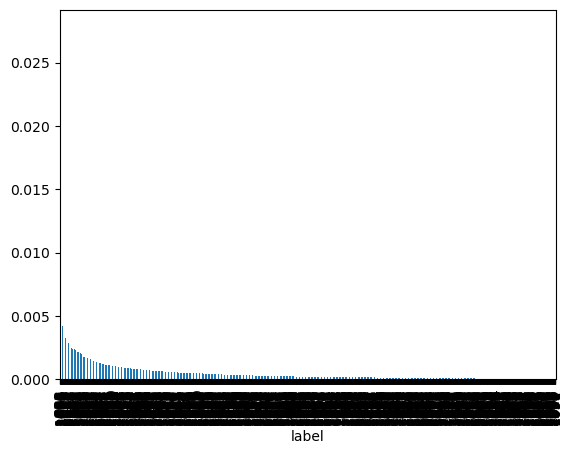

In [ ]:
X = df_subject['text']
y = df_subject['label']
y.value_counts(normalize=True).plot(kind='bar')

<AxesSubplot:xlabel='label'>

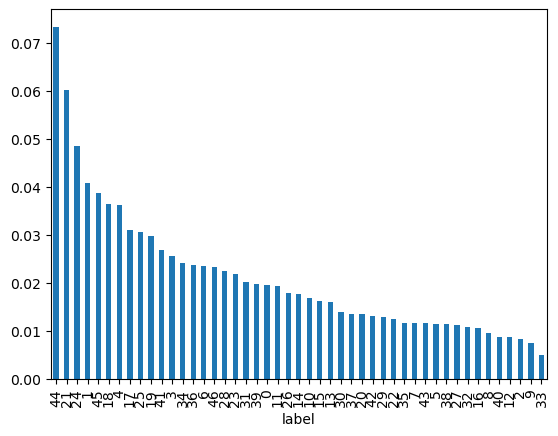

In [ ]:
X = df_volume['text']
y = df_volume['label']
y.value_counts(normalize=True).plot(kind='bar')

# B1.ii

In [17]:
#Vectorization with pretrained Word2Vec
def text_to_vector(text, model, stopwords, dim=300):
    words = re.findall(r'\w+', text.lower())
    words = [w for w in words if clean_word(w) not in stopwords]
    vectors = [model[w] for w in words if w in model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

def process_and_train_pretrained_word2vec_gensim(df, embedding_path, stopwords_path='stopwords-el.txt', dim=300):
    """
    Εκπαιδεύει Logistic Regression με προεκπαιδευμένα Word2Vec ή fastText embeddings (.vec format).
    """

    # Loading stopwords
    with open(stopwords_path, encoding='utf-8') as f:
        stopwords = [clean_word(line) for line in f if line.strip()]

    # Removal of labels with less than 5 samples
    label_counts = df['label'].value_counts()
    valid_labels = label_counts[label_counts >= 5].index
    df_filtered = df[df['label'].isin(valid_labels)].copy()

    # Loading embeddings
    print(" Loading embeddings...")
    model = KeyedVectors.load_word2vec_format(embedding_path, binary=False)

    # Vectorization
    print(" Vectorizing texts...")
    df_filtered['vector'] = df_filtered['text'].apply(lambda x: text_to_vector(x, model, stopwords, dim))
    X = np.stack(df_filtered['vector'].values)
    y = df_filtered['label'].values

    # Train / Validation / Test split
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42)

    # GridSearchCV
    param_grid = {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear'],
        'max_iter': [1000]
    }

    print(" Running GridSearchCV...")
    clf = LogisticRegression()
    grid = GridSearchCV(clf, param_grid, scoring='f1_macro', cv=5, n_jobs=-1, verbose=1)
    grid.fit(X_val, y_val)
    print(" Best parameters:", grid.best_params_)

    # Train the best model on the full training set
    best_model = LogisticRegression(**grid.best_params_)
    best_model.fit(X_train_full, y_train_full)


    y_pred = best_model.predict(X_test)

    print("\n Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    results = {
        'Accuracy': [accuracy_score(y_test, y_pred)],
        'Precision (macro)': [precision_score(y_test, y_pred, average='macro', zero_division=0)],
        'Recall (macro)': [recall_score(y_test, y_pred, average='macro', zero_division=0)],
        'F1-score (macro)': [f1_score(y_test, y_pred, average='macro', zero_division=0)],
        'Precision (weighted)': [precision_score(y_test, y_pred, average='weighted', zero_division=0)],
        'Recall (weighted)': [recall_score(y_test, y_pred, average='weighted', zero_division=0)],
        'F1-score (weighted)': [f1_score(y_test, y_pred, average='weighted', zero_division=0)]
    }

    df_results = pd.DataFrame(results, index=['LogReg + Word2Vec'])
    return df_results


## Volume

In [ ]:
results_lr_vol = process_and_train_pretrained_word2vec_gensim(df_volume, embedding_path='cc.el.300.vec')
display(results_lr_vol)


 Loading embeddings...
 Vectorizing texts...
 Running GridSearchCV...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Best parameters: {'C': 10, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}

 Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.63      0.59       112
           1       0.58      0.70      0.63       234
           2       0.74      0.43      0.54        47
           3       0.51      0.47      0.49       146
           4       0.54      0.62      0.58       208
           5       0.66      0.42      0.51        65
           6       0.71      0.70      0.70       135
           7       0.64      0.62      0.63        66
           8       0.79      0.47      0.59        55
           9       0.59      0.38      0.46        42
          10       0.48      0.33      0.40        96
          11       0.64      0.67      0.66       110
          12       0.70      0.46      0.55        50
  

,Accuracy,Precision (macro),Recall (macro),F1-score (macro),Precision (weighted),Recall (weighted),F1-score (weighted)
LogReg + Word2Vec,0.619481,0.604609,0.543201,0.563157,0.616946,0.619481,0.610817


## Chapter

In [ ]:
results_lr_chap = process_and_train_pretrained_word2vec_gensim(df_chapter, embedding_path='cc.el.300.vec')
display(results_lr_chap)


 Loading embeddings...
 Vectorizing texts...
 Running GridSearchCV...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\Maria\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


 Best parameters: {'C': 10, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}

 Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.67      0.59        27
           1       0.62      0.50      0.55        16
           2       1.00      0.20      0.33         5
           3       0.18      0.15      0.17        13
           4       0.00      0.00      0.00         1
           5       0.42      0.36      0.38        14
           6       0.37      0.65      0.47        17
           7       0.42      0.42      0.42        12
           8       0.36      0.65      0.46        37
           9       0.00      0.00      0.00         3
          10       1.00      0.25      0.40         4
          11       0.59      0.45      0.51        22
          13       0.00      0.00      0.00         1
          14       0.54      0.62      0.58        21
          15       0.00      0.00      0.00         4
          16       0.00 

,Accuracy,Precision (macro),Recall (macro),F1-score (macro),Precision (weighted),Recall (weighted),F1-score (weighted)
LogReg + Word2Vec,0.452694,0.314637,0.249746,0.254035,0.42714,0.452694,0.412042


## Subject

In [ ]:
results_lr_sub = process_and_train_pretrained_word2vec_gensim(df_subject, embedding_path='cc.el.300.vec')
display(results_lr_sub)


 Loading embeddings...
 Vectorizing texts...
 Running GridSearchCV...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\Maria\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


 Best parameters: {'C': 10, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}

 Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.17      0.25         6
           8       0.50      0.17      0.25         6
           9       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         3
          17       0.00      0.00      0.00         4
          19       0.00      0.00      0.00         3
          20       0.00      0.00      0.00         2
          22       0.00      0.00      0.00         1
          25       0.36      0.33      0.35        12
          27       0.50      0.25      0.33         4
          29       0.00      0.00      0.00         1
          30       0.00      0.00      0.00         3
          32       0.56      0.56      0.56         9
          33       0.00      0.00      0.00         3
          34       0.17 

,Accuracy,Precision (macro),Recall (macro),F1-score (macro),Precision (weighted),Recall (weighted),F1-score (weighted)
LogReg + Word2Vec,0.266353,0.119773,0.100262,0.098385,0.231103,0.266353,0.219748


# B1.iii

In [ ]:
def process_and_train_nb_tfidf(df, stopwords_path='stopwords-el.txt', max_features=10000):
    """
    TF-IDF + Multinomial Naive Bayes με GridSearchCV για Β1.iii της εργασίας.

    """

    # Loading stopwords
    with open(stopwords_path, encoding='utf-8') as f:
        stopwords = [re.sub(r'[^\w\s]', '', line.strip().lower()) for line in f if line.strip()]

    # Filtering labels with less than 5 samples
    label_counts = df['label'].value_counts()
    valid_labels = label_counts[label_counts >= 5].index
    df_filtered = df[df['label'].isin(valid_labels)].copy()

    # Cleaning the text
    df_filtered['clean_text'] = df_filtered['text'].apply(clean_text)

    # 4. TF-IDF vectorization
    print(" Creating TF-IDF vectors...")
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        stop_words=stopwords
    )
    X = vectorizer.fit_transform(df_filtered['clean_text'])
    y = df_filtered['label'].values

    # Train/Validation/Test split
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, stratify=y_train_full, test_size=0.2, random_state=42)

    #  GridSearchCV για Naive Bayes
    nb = MultinomialNB()
    param_grid = {'alpha': [0.1, 0.5, 1.0]}
    print("GridSearchCV for TF-IDF + Naive Bayes...")
    grid = GridSearchCV(
        estimator=nb,
        param_grid=param_grid,
        scoring='f1_macro',
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_val, y_val)
    print(" Best parameters:", grid.best_params_)

    # Train the best model on the full training set
    best_model = MultinomialNB(**grid.best_params_)
    best_model.fit(X_train_full, y_train_full)

    y_pred = best_model.predict(X_test)

    print("\n Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    metrics_df = pd.DataFrame([{
        'Model': 'TF-IDF + Naive Bayes',
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision (macro)': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'Recall (macro)': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'F1-score (macro)': f1_score(y_test, y_pred, average='macro', zero_division=0),
        'Precision (weighted)': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall (weighted)': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1-score (weighted)': f1_score(y_test, y_pred, average='weighted', zero_division=0)


    }]).set_index('Model')

    return metrics_df


## Volume

In [ ]:
results_nb_vol = process_and_train_nb_tfidf(df_volume)
display(results_nb_vol)


 Creating TF-IDF vectors...
GridSearchCV for TF-IDF + Naive Bayes...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
 Best parameters: {'alpha': 0.1}

 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.59      0.67       112
           1       0.66      0.79      0.72       234
           2       0.89      0.34      0.49        47
           3       0.74      0.73      0.73       146
           4       0.72      0.77      0.75       208
           5       0.86      0.58      0.70        65
           6       0.94      0.81      0.87       135
           7       0.79      0.56      0.65        66
           8       0.89      0.60      0.72        55
           9       1.00      0.31      0.47        42
          10       0.79      0.48      0.60        96
          11       0.79      0.79      0.79       110
          12       0.93      0.50      0.65        50
          13       0.81      0.74      0.77        91
   

,Accuracy,Precision (macro),Recall (macro),F1-score (macro),Precision (weighted),Recall (weighted),F1-score (weighted)
Model,,,,,,,
TF-IDF + Naive Bayes,0.724071,0.762676,0.647445,0.680573,0.744236,0.724071,0.719398


## Chapter

In [ ]:
results_nb_chap = process_and_train_nb_tfidf(df_chapter)
display(results_nb_chap)


 Creating TF-IDF vectors...
GridSearchCV for TF-IDF + Naive Bayes...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


 Best parameters: {'alpha': 0.1}

 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        27
           1       0.86      0.38      0.52        16
           2       1.00      0.40      0.57         5
           3       0.86      0.46      0.60        13
           4       0.00      0.00      0.00         1
           5       0.62      0.57      0.59        14
           6       0.42      0.88      0.57        17
           7       0.75      0.75      0.75        12
           8       0.51      0.65      0.57        37
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         4
          11       0.62      0.73      0.67        22
          13       0.00      0.00      0.00         1
          14       0.88      0.67      0.76        21
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         4
          17       0.88

,Accuracy,Precision (macro),Recall (macro),F1-score (macro),Precision (weighted),Recall (weighted),F1-score (weighted)
Model,,,,,,,
TF-IDF + Naive Bayes,0.560295,0.52331,0.321181,0.354339,0.62649,0.560295,0.527406


## Subject

In [ ]:
results_nb_sub = process_and_train_nb_tfidf(df_subject)
display(results_nb_sub)


 Creating TF-IDF vectors...
GridSearchCV for TF-IDF + Naive Bayes...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


 Best parameters: {'alpha': 0.1}

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         6
           8       0.67      0.33      0.44         6
           9       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         3
          17       0.00      0.00      0.00         4
          19       0.00      0.00      0.00         3
          20       0.00      0.00      0.00         2
          22       0.00      0.00      0.00         1
          25       1.00      0.58      0.74        12
          27       1.00      0.25      0.40         4
          29       0.00      0.00      0.00         1
          30       0.00      0.00      0.00         3
          32       0.83      0.56      0.67         9
          33       0.00      0.00      0.00         3
          34       0.57      0.67      0.62         6
          37       0.00

,Accuracy,Precision (macro),Recall (macro),F1-score (macro),Precision (weighted),Recall (weighted),F1-score (weighted)
Model,,,,,,,
TF-IDF + Naive Bayes,0.342105,0.235785,0.139688,0.160196,0.433913,0.342105,0.329986


# Result Tables

## Volume

In [5]:
import pandas as pd

# Same data from earlier
data = [
    ["Dummy Classifier (TF-IDF)", 0.073406, 0.001562, 0.021277, 0.002910, 0.005388, 0.073406, 0.010040],
    ["SVM + BOW", 0.781359, 0.784480, 0.740756, 0.758667, 0.784789, 0.781359, 0.779932],
    ["SVM + TF-IDF", 0.825158, 0.823513, 0.799345, 0.806821, 0.825982, 0.825158, 0.824162],
    ["LogReg + Word2Vec", 0.619481, 0.604609, 0.543201, 0.563157, 0.616946, 0.619481, 0.610817],
    ["TF-IDF + Naive Bayes", 0.724071, 0.762676, 0.647445, 0.680573, 0.744236, 0.724071, 0.719398],
]

columns = [
    "Model",
    "Accuracy",
    "Precision (macro)",
    "Recall (macro)",
    "F1-score (macro)",
    "Precision (weighted)",
    "Recall (weighted)",
    "F1-score (weighted)"
]

df = pd.DataFrame(data, columns=columns)

# Display as structured table in notebook
print("VOLUME TABLE")
display(df)


VOLUME TABLE


,Model,Accuracy,Precision (macro),Recall (macro),F1-score (macro),Precision (weighted),Recall (weighted),F1-score (weighted)
0,Dummy Classifier (TF-IDF),0.073406,0.001562,0.021277,0.002910,0.005388,0.073406,0.010040
1,SVM + BOW,0.781359,0.784480,0.740756,0.758667,0.784789,0.781359,0.779932
2,SVM + TF-IDF,0.825158,0.823513,0.799345,0.806821,0.825982,0.825158,0.824162
3,LogReg + Word2Vec,0.619481,0.604609,0.543201,0.563157,0.616946,0.619481,0.610817
4,TF-IDF + Naive Bayes,0.724071,0.762676,0.647445,0.680573,0.744236,0.724071,0.719398


## Chapter

In [6]:
import pandas as pd

# Chapter classification metrics (extracted from screenshots)
chapter_data = [
    ["Dummy Classifier (TF-IDF)", 0.027734, 0.000077, 0.002762, 0.000149, 0.000769, 0.027734, 0.001497],
    ["SVM + BOW", 0.689310, 0.619234, 0.565990, 0.576559, 0.691870, 0.689310, 0.682247],
    ["SVM + TF-IDF", 0.751624, 0.695698, 0.660987, 0.666224, 0.751764, 0.751624, 0.745346],
    ["LogReg + Word2Vec", 0.452694, 0.314637, 0.249746, 0.254035, 0.427140, 0.452694, 0.412042],
    ["TF-IDF + Naive Bayes", 0.560295, 0.523310, 0.321181, 0.354339, 0.626490, 0.560295, 0.527406],
]

chapter_columns = [
    "Model",
    "Accuracy",
    "Precision (macro)",
    "Recall (macro)",
    "F1-score (macro)",
    "Precision (weighted)",
    "Recall (weighted)",
    "F1-score (weighted)"
]

# Create the DataFrame
chapter_results_df = pd.DataFrame(chapter_data, columns=chapter_columns)

print("CHAPTER TABLE")
display(chapter_results_df)



CHAPTER TABLE


,Model,Accuracy,Precision (macro),Recall (macro),F1-score (macro),Precision (weighted),Recall (weighted),F1-score (weighted)
0,Dummy Classifier (TF-IDF),0.027734,0.000077,0.002762,0.000149,0.000769,0.027734,0.001497
1,SVM + BOW,0.689310,0.619234,0.565990,0.576559,0.691870,0.689310,0.682247
2,SVM + TF-IDF,0.751624,0.695698,0.660987,0.666224,0.751764,0.751624,0.745346
3,LogReg + Word2Vec,0.452694,0.314637,0.249746,0.254035,0.427140,0.452694,0.412042
4,TF-IDF + Naive Bayes,0.560295,0.523310,0.321181,0.354339,0.626490,0.560295,0.527406


## Subject

In [7]:
# Subject classification metrics (from screenshots)
subject_data = [
    ["Dummy Classifier (TF-IDF)", 0.029887, 0.000024, 0.000811, 0.000047, 0.000893, 0.029887, 0.001735],
    ["SVM + BOW", 0.637406, 0.554253, 0.525795, 0.521547, 0.623081, 0.637406, 0.612828],
    ["SVM + TF-IDF", 0.694549, 0.621555, 0.616241, 0.598766, 0.686375, 0.694549, 0.675182],
    ["LogReg + Word2Vec", 0.266353, 0.119773, 0.100262, 0.098385, 0.231103, 0.266353, 0.219748],
    ["TF-IDF + Naive Bayes", 0.342105, 0.235785, 0.139688, 0.160196, 0.433913, 0.342105, 0.329986],
]

subject_columns = [
    "Model",
    "Accuracy",
    "Precision (macro)",
    "Recall (macro)",
    "F1-score (macro)",
    "Precision (weighted)",
    "Recall (weighted)",
    "F1-score (weighted)"
]

# Create DataFrame and display it
subject_results_df = pd.DataFrame(subject_data, columns=subject_columns)
print("SUBJECT TABLE")
display(subject_results_df)


SUBJECT TABLE


,Model,Accuracy,Precision (macro),Recall (macro),F1-score (macro),Precision (weighted),Recall (weighted),F1-score (weighted)
0,Dummy Classifier (TF-IDF),0.029887,0.000024,0.000811,0.000047,0.000893,0.029887,0.001735
1,SVM + BOW,0.637406,0.554253,0.525795,0.521547,0.623081,0.637406,0.612828
2,SVM + TF-IDF,0.694549,0.621555,0.616241,0.598766,0.686375,0.694549,0.675182
3,LogReg + Word2Vec,0.266353,0.119773,0.100262,0.098385,0.231103,0.266353,0.219748
4,TF-IDF + Naive Bayes,0.342105,0.235785,0.139688,0.160196,0.433913,0.342105,0.329986
